# Linear Elasticity-Perfect Plasticity

This example can be found in Section 5.3 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

### Generic functions and imports

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm

from src.material_model import LinearElasticityPerfectPlasticity as LEPP
from src.sampler import MetropolisHastings, AdaptiveMetropolisHastings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

save_figures = False

In [2]:
def add_labels(graph_title, x_label, y_label):
    """
    Add labels to graphs
    """
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Constitutive model and *true* material parameters

It is assumed that the behaviour of the material specimen can be accurately described by a linear elastic-perfectly plastic law that is defined by two parameters: (1) Young's modulus $E$ and (2) yield stress $\sigma_{y0}$.

The stress-strain response of the linear elastic-perfectly plastic model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Where $\textbf{x}$ is the parameter vector:

$$\textbf{x} = [E \; \sigma_{y0}]^T$$

and $E$ is the Young's modulus and $\sigma_{y0}$ is the initial yield stress. Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

The *true* material parameters that we are attempting to identify (infer) are:

$$E = 210 \; \textrm{GPa} \quad \sigma_{y0} = 0.25 \; \textrm{GPa}$$

The *true* stress-strain response is illustrated in the following figure.

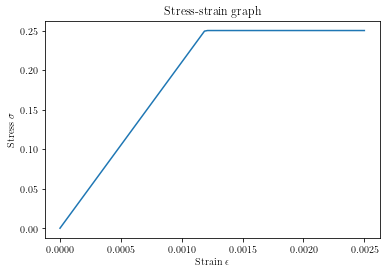

In [3]:
E = 210           # Young's modulus (GPa)
stress_y = 0.25   # Yield stress (GPa)
s_noise = 0.01    # Noise in the stress measurement (GPa)

model = LEPP(E, stress_y, s_noise)
strain = np.linspace(0, 2.5E-3, 100)
model.stress_strain_response(strain)

## Noisy experimental observations (stress-strain response)

The experimental observations are contaminated by noise. Note that only the stress measurement is contaimated by noise but we will consider an example later where the strain measurement is also contaminated by noise.

The observations are generated numerically so that they deviate from the true constitutive model. The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$. The number of generated observations can be selected by the user. They will note that increasing the number of observations reduces the uncertainty in the estimates of the material parameters.

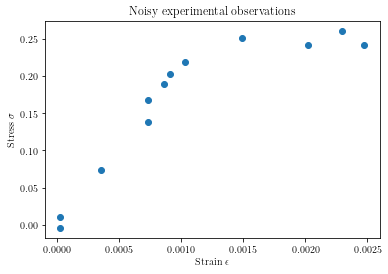

In [4]:
strain_data, stress_data = model.generate_synthetic_data(strain, 12, seed=12345) # seed=54321
plt.scatter(strain_data, stress_data);
add_labels("Noisy experimental observations", "Strain $\epsilon$", "Stress $\sigma$")

## Likelihood $\pi(y|\textbf{x})$

The likelihood function for a single stress measurement is given by the following equation

$$\pi(y|\textbf{x}) = \pi_{noise}(y - \sigma(\epsilon, \textbf{x})) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - \sigma(\epsilon, \textbf{x})\right)^2}{2s^2_{noise}}}\right)$$

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior $\pi(\textbf{x})$

Choosing the prior distribution in the form of a modified normal distribution:

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

The following mean vector (prior candidate vector) and convariance matrix are selected:

$$\overline{\textbf{x}} = \begin{bmatrix} 200 \\ 0.29 \end{bmatrix} \; \text{GPa}, \quad \Gamma_\textbf{x} = \begin{bmatrix} 2500 & 0 \\ 0 & 2.7778 \times 10^{-4} \end{bmatrix} \; \text{GPa}^2$$

In [5]:
x_prior = np.array([[200], [0.29]])                       # Mean vector (GPa)
cov_matrix_prior = np.array([[2500, 0], [0, 2.7778E-4]])  # Covariance matrix (GPa^2)
model.set_priors(x_prior, cov_matrix_prior)

## Posterior $\pi(\textbf{x}|\textbf{y})$

The posterior distribution for a single stress measurement is given by the following equation:

$$\pi(\textbf{x}|y) \propto \pi(\textbf{x})\pi(y|\textbf{x}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

If we now consider the posterior distribution of the previous measurement to be the prior distribution of the current measurement, the posterior for all $n_m$ measurements can be expressed as:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x})) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

Where $n_m$ is the number of measurements, $y_i$ is the measured stress and $\epsilon_i$ is the measured strain.

In [6]:
x_candidate = np.array([[210], [0.25]])
print(model.posterior(strain_data, stress_data, x_candidate))

x_candidate = np.array([[200], [0.29]])
print(model.posterior(strain_data, stress_data, x_candidate))

[[4.49041694e+15]]
[[4.82141864]]


## Identification of the material parameters: Metropolis-Hastings method

Determine the PDF for the Young's modulus $E$ and yield stress $\sigma_{y0}$ using the standard Metropolis-Hastings method.

In [7]:
data = [strain_data, stress_data]
mh = MetropolisHastings(model, data, n_samples=1E5, step_size=np.array([[2.5], [0.05]]))

x_0 = np.array([[200], [0.29]])  # Initial sample
x_hist, pdf_hist, accept_rate = mh.sample(x_0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3507.75it/s]


The chain is run for 1E5 samples and the first 3000 samples are burnt (i.e. the first 3000 samples are not used to determine the mean, the covariance matrix and the MAP estimate).

In [8]:
x_mean = mh.calculate_mean(x_hist)
print(x_mean)

[214.34514505   0.25230421]


In [9]:
x_cov = mh.calculate_covariance(x_hist)
print(x_cov)

[[2.77642545e+01 1.00978143e-04]
 [1.00978143e-04 2.31047405e-05]]


### Visualise the proposal distribution

Move to MCMC notebook

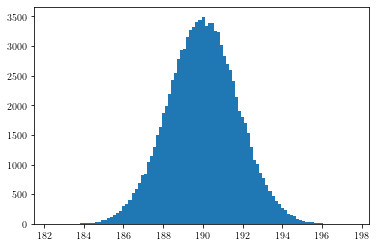

In [10]:
n_samples = 100000
x_i = ([190], [0.2])
x_p = np.zeros([n_samples, np.size(x_i)])

for i in range(n_samples):
    x_p[i, :] = np.transpose(mh.draw_proposal(x_i))

plt.hist(x_p[:, 0], 100);

### Posterior

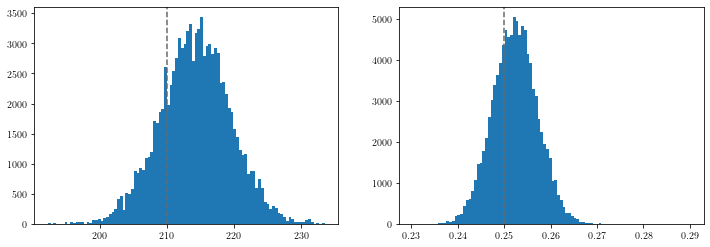

In [11]:
# Histogram of the Markov chain values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(x_hist[:, 0], 100);
ax2.hist(x_hist[:, 1], 100);
ax1.axvline(E, ls='--', color='dimgray')
ax2.axvline(stress_y, ls='--', color='dimgray')

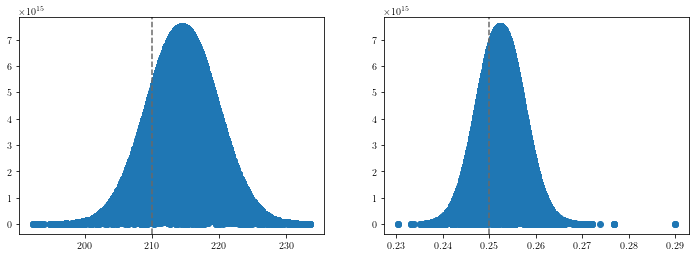

In [12]:
# Density plot of the Markov chain values - use kernel density estimation or marginal distribution? Look at Seaborn?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(x_hist[:, 0], pdf_hist);
ax2.scatter(x_hist[:, 1], pdf_hist);
ax1.axvline(E, ls='--', color='dimgray')
ax2.axvline(stress_y, ls='--', color='dimgray')

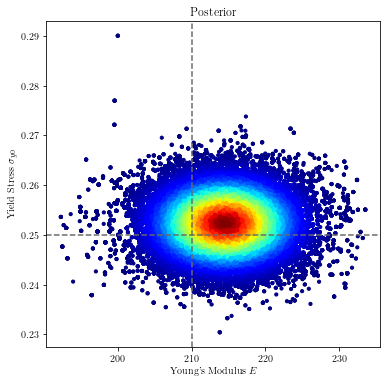

In [13]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(x_hist[:,0], x_hist[:,1], s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
plt.axvline(E, ls='--', color='dimgray')
plt.axhline(stress_y, ls='--', color='dimgray')

if save_figures:
    fig.savefig('LEPP_posterior.png', dpi=300) 

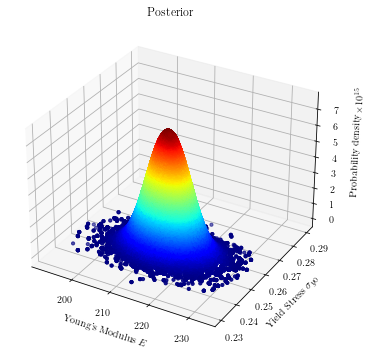

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_hist[:,0], x_hist[:,1], pdf_hist, s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
ax.set_zlabel('Probability density');

### Convergence

A commonly employed approach to check the stability and convergence of the scheme is to trace the generated samples and analyse their characteristics.

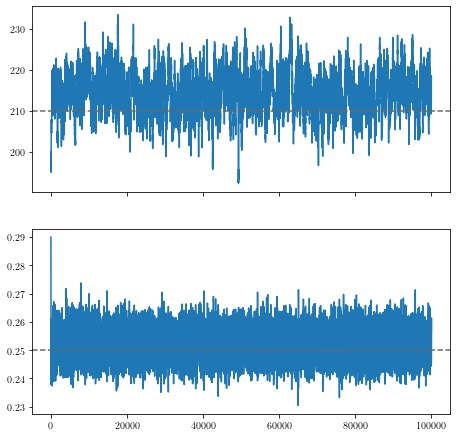

In [15]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7.5, 7.5))
ax1.plot(x_hist[:, 0])
ax1.axhline(E, ls='--', color='dimgray')
ax2.plot(x_hist[:, 1])
ax2.axhline(stress_y, ls='--', color='dimgray')

### Acceptance rate

It has been shown that optimal acceptance rate is approximately 0.25 [[1]](https://arxiv.org/pdf/1504.01896.pdf). If the acceptance rate is too high or too low it will slow down the convergence of the Markov chain.

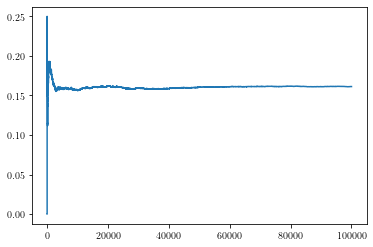

In [16]:
plt.plot(accept_rate)

## Identification of the material parameters: Adaptive Metropolis-Hastings method

In [17]:
data = [strain_data, stress_data]
mh_ap = AdaptiveMetropolisHastings(model, data, n_samples=2E5)

x_0 = np.array([[200], [0.29]])  # Initial sample
x_hist, pdf_hist, accept_rate = mh_ap.sample(x_0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [01:01<00:00, 3231.83it/s]


### Posterior

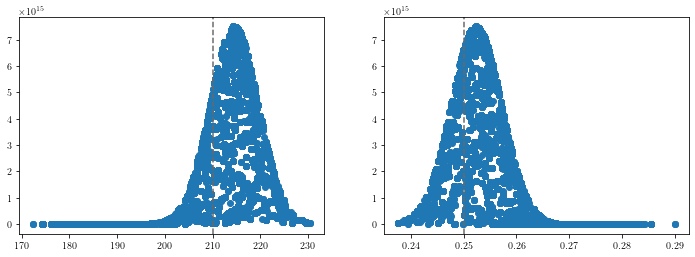

In [18]:
# Density plot of the Markov chain values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(x_hist[:, 0], pdf_hist);
ax2.scatter(x_hist[:, 1], pdf_hist);
ax1.axvline(E, ls='--', color='dimgray')
ax2.axvline(stress_y, ls='--', color='dimgray')

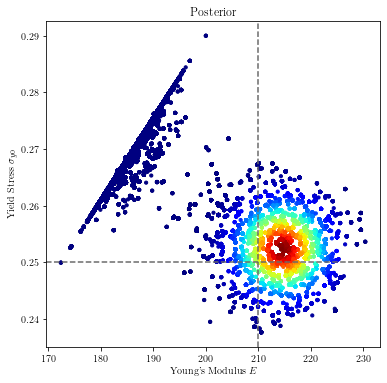

In [19]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(x_hist[:,0], x_hist[:,1], s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
plt.axvline(E, ls='--', color='dimgray')
plt.axhline(stress_y, ls='--', color='dimgray')

if save_figures:
    fig.savefig('LEPP_posterior_adaptive.png', dpi=300) 

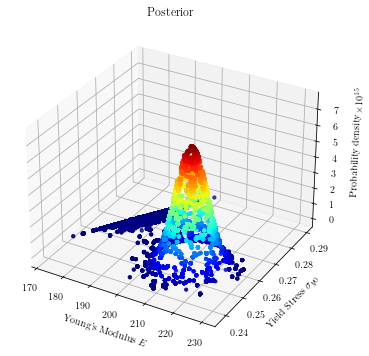

In [20]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_hist[:,0], x_hist[:,1], pdf_hist, s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
ax.set_zlabel('Probability density');

### Convergence

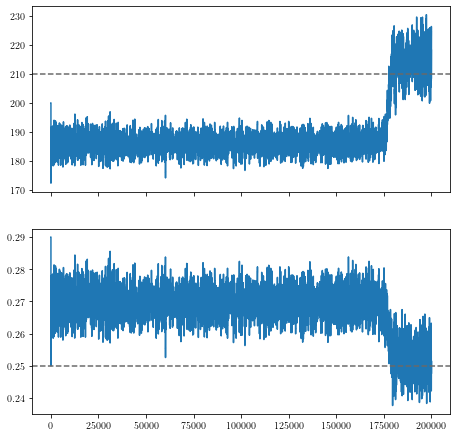

In [21]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7.5, 7.5))
ax1.plot(x_hist[:, 0])
ax1.axhline(E, ls='--', color='dimgray')
ax2.plot(x_hist[:, 1])
ax2.axhline(stress_y, ls='--', color='dimgray')

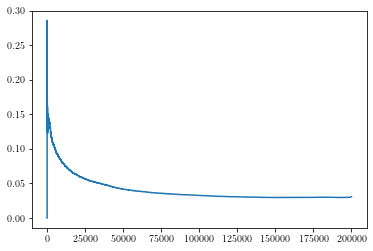

In [22]:
plt.plot(accept_rate)

## Posterior Predictive Distribution (PPD)

The posterior predictive distribution is the distribution of possible unobserved values conditional on the observed values.

$$\pi(y^{\textrm{new}}|\textbf{y}, \boldsymbol{\epsilon}, \epsilon^{\textrm{new}}) = \int_{\mathbb{R}^{n_p}} \pi(y^{\textrm{new}}|\textbf{x}, \epsilon^{\textrm{new}}) \pi(\textbf{x}|\textbf{y}, \boldsymbol{\epsilon}) dx$$


Note that $\pi(\textbf{x}|\textbf{y}, \boldsymbol{\epsilon})$ has already been computed. The $i^{th}$ sample is replaced in $\pi(y^{\textrm{new}}|\textbf{x}_i, \epsilon^{\textrm{new}})$, which is subsequently used to generate a sample for new measurement $y_i^{new}$.

### Prediction bounds

The below figure illustrates the stress-strain response using parameters drawn from the **95% credible region** of the posterior as well as the posterior predictions. The 95% credible region is the region that contains 95% of the posterior.

The **95% prediction interval** is obtained using the posterior predictive distribution and its upper and lower bounds read:

$$\textrm{prediction bounds} = \overline{\textrm{PPD}} \pm 2S_{\textrm{PDD}}$$

where $\overline{\textrm{PPD}}$ denotes the mean of posterior predictive distributions for the new measurement (i.e. $y_{\textrm{new}}$ in Eq. (59)) and $s_{\textrm{PDD}}$ denotes its standard deviation.
